# ODEs and neural networks

In a number of cases the right hand side of a system of ordinary differential equations contain an artificial neural network (ANN). This is the case, for example, in controlled systems where the state-feedback is provided via a neural network, or 
in those cases where the ANN has been trained to describe nonlinear interactions or external disturbances, but also in more advanced scenarios where the full system of ODEs is a ANN trained to reproduce some observed or desired dynamics. A particularly significant case, in the context of Taylor integration, is when the ANN is used to represent, via a differentiable expression, that of an ANN, some otherwise discontinuous or non differentiable term.

In all cases we must solve a system in the form:

$$
\dot {\mathbf x} = \mathbf f(\mathbf x, \mathcal N_\theta(\mathbf x))
$$

where we have denoted with $\theta$ the network model parameters. 

In order to facilitate to instantiate such a system, *heyoka.py* implements, in its module *model*, a Feed Forward Neural Network factory called ``ffnn()``. The Neural Network inputs $\mathbf {in}$, with dimensionality $n_{in}$ are fed into a succession of $N \ge 0 $ neural layers defined by:

$$
\mathbf h_i = F_i(\mathbf W_i\mathbf h_{i-1} + \mathbf b_i), \quad i = 1 .. N
$$

to derive the Neural Network outputs $\mathbf {out}$ with dimensionality $n_{out}$:

$$
\mathbf {out} = F_{N+1}(\mathbf W_{N+1}\mathbf h_{N} + \mathbf b_{N+1})
$$

where $\mathbf h_0 = \mathbf {in}$ and $F_i$ define the network non-linearities, or activation functions.

We here show how to use this factory in the context of inference as well as in definition of the dynamics of an adaptive Taylor integrator.

In [1]:
# The usual main imports
import heyoka as hy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Let us start with something simple and small, without hidden layers and with one only input and output, to illustrate the basics of such a factory.

In [2]:
# We create the symbols for the network inputs (only one in this frst simple case)
x, = hy.make_vars("x")

# We define as nonlinearity a simple linear layer
linear = lambda inp: inp

# We call the factory to construct the FFNN:
ffnn = hy.model.ffnn(inputs = [x], nn_hidden = [], n_out = 1, activations = [linear])
print(ffnn)


[(p1 + (p0 * x))]


The factory ``ffnn()`` returns a list of ``heyoka.expression`` representing each of the output neurons, in this case only one. 
The same syntax can be used to instantiate a more complex case:

In [3]:
x, y = hy.make_vars("x", "y")
ffnn = hy.model.ffnn(inputs = [x, y], nn_hidden = [32], n_out = 2, activations = [hy.tanh, linear])
print(ffnn)

[(p160 + (p64 * tanh((p128 + (p0 * x) + (p1 * y)))) + (p65 * tanh((p129 + (p2 * x) + (p3 * y)))) + (p66 * tanh((p130 + (p4 * x) + (p5 * y)))) + (p67 * tanh((p131 + (p6 * x) + (p7 * y)))) + (p68 * tanh((p132 + (p8 * x) + (p9 * y)))) + (p69 * tanh((p133 + (p10 * x) + (p11 * y)))) + (p70 * tanh((p134 + (p12 * x) + (p13 * y)))) + (p71 * tanh((p135 + (p14 * x) + (p15 * y)))) + (p72 * tanh((p136 + (p16 * x) + (p17 * y)))) + (p73 * tanh((p137 + (p18 * x) + (p19 * y)))) + (p74 * tanh((p138 + (p20 * x) + (p21 * y)))) + (p75 * tanh((p139 + (p22 * x) + (p23 * y)))) + (p76 * tanh((p140 + (p24 * x) + (p25 * y)))) + (p77 * tanh((p141 + (p26 * x) + (p27 * y)))) + (p78 * tanh((p142 + (p28 * x) + (p29 * y)))) + (p79 * tanh((p143 + (p30 * x) + (p31 * y)))) + (p80 * tanh((p144 + (p32 * x) + (p33 * y)))) + (p81 * tanh((p145 + (p34 * x) + (p35 * y)))) + (p82 * tanh((p146 + (p36 * x) + (p37 * y)))) + (p83 * tanh((p147 + (p38 * x) + (p39 * y)))) + (p84 * tanh((p148 + (p40 * x) + (p41 * y)))) + (p85 * tanh((p

The resulting screen output of the built expression is much longer and eventually it actually makes little sense to print it.

> **NOTE**: The user must take care of consistency of the dimensions of the various kwargs passed into the factory, else an error will be raised. For example, the dimension of the list containing the activation functions must be exactly one more than the dimension of the *nn_hidden* and so on.

All the network parameters, i.e. the weights and biases, are, by default, defined as ``par[j]`` in the *heyoka* expression system. This flattens the weight matrices $\mathbf W_i, i=1 .. (N-1)$ and then the biases $\mathbf b_i, i=1 .. (N-1)$ into one non-dimensional vector. In this case we have that $\mathbf W_1$ is a (2,32) matrix, $\mathbf W_2$ is a (32,2) matrix, $\mathbf b_1$ is a (32,1) vector and $\mathbf b_2$ a (2,1) vector. A total of 2x32+32x2+32+2=162 parameters are then needed.

We now assume the matrices and biases are available (for example from some third party code that trained the model) and for the sake of the tutorial we create them here randomly. 

In [4]:
# To simulate that the network parameters are coming from some third party tool that performed the network training, 
# we here generate them as random numpy arrays.
W1 = np.random.random((2,32))
W2 = np.random.random((32,2))
b1 =  np.random.random((32,1))
b2 =  np.random.random((2,1))

And we flatten them into the *heyoka* format (i.e. first weights then biases):

In [5]:
flattened_nw = np.concatenate((W1.flatten(), W2.flatten(), b1.flatten(), b2.flatten()))

## Inference
In order to use the ffnn to make inferences, we must compile it into a cfunction. Thats easy though, specially if you have followed the [compiled functions](<./compiled_functions.ipynb>) tutorial:

In [6]:
cf = hy.make_cfunc(ffnn)
print(cf)

[2023-11-04 00:07:25.120] [heyoka] [info] heyoka logger initialised
Variables: [x, y]
Output #0: (p160 + (p64 * tanh((p128 + (p0 * x) + (p1 * y)))) + (p65 * tanh((p129 + (p2 * x) + (p3 * y)))) + (p66 * tanh((p130 + (p4 * x) + (p5 * y)))) + (p67 * tanh((p131 + (p6 * x) + (p7 * y)))) + (p68 * tanh((p132 + (p8 * x) + (p9 * y)))) + (p69 * tanh((p133 + (p10 * x) + (p11 * y)))) + (p70 * tanh((p134 + (p12 * x) + (p13 * y)))) + (p71 * tanh((p135 + (p14 * x) + (p15 * y)))) + (p72 * tanh((p136 + (p16 * x) + (p17 * y)))) + (p73 * tanh((p137 + (p18 * x) + (p19 * y)))) + (p74 * tanh((p138 + (p20 * x) + (p21 * y)))) + (p75 * tanh((p139 + (p22 * x) + (p23 * y)))) + (p76 * tanh((p140 + (p24 * x) + (p25 * y)))) + (p77 * tanh((p141 + (p26 * x) + (p27 * y)))) + (p78 * tanh((p142 + (p28 * x) + (p29 * y)))) + (p79 * tanh((p143 + (p30 * x) + (p31 * y)))) + (p80 * tanh((p144 + (p32 * x) + (p33 * y)))) + (p81 * tanh((p145 + (p34 * x) + (p35 * y)))) + (p82 * tanh((p146 + (p36 * x) + (p37 * y)))) + (p83 * tanh(

Let us now make an inference of the point [1.2, -2.2]

In [7]:
cf([1.2,-2.2], pars = flattened_nw)

array([3.77327396, 2.35923845])

The backdraw here is that at each inference the actual values of all the parameters must be copied into the expression upon evaluatio, which may result in slower performances. Hardcoding the values into the FFNN is surely a better option, which can be achieved using the optional kwarg *nn_wb* (neural network weights and biases) of the factory ``ffnn()``:

In [8]:
ffnn = hy.model.ffnn(inputs = [x, y], nn_hidden = [32], n_out = 2, activations = [hy.tanh, linear], nn_wb = flattened_nw)
print(ffnn)

[(0.20775307452917735 + (0.0010130547168091253 * tanh((0.81871568375331039 + (0.40179542424902293 * y) + (0.90220395133840459 * x)))) + (0.014374383937949320 * tanh((0.45888687488955759 + (0.26945635036856630 * x) + (0.77331407562325083 * y)))) + (0.041118449009451941 * tanh((0.036971172706964373 + (0.46259220410875757 * y) + (0.56969805323760492 * x)))) + (0.13239743898202583 * tanh((0.36677374337928526 + (0.38923986810536348 * x) + (0.82881886260142812 * y)))) + (0.15751196911336651 * tanh((0.89274223830374810 + (0.26764702764559190 * y) + (0.81026214395929874 * x)))) + (0.19270808338748058 * tanh((0.047426267194027316 + (0.38053793959559201 * y) + (0.66495719156913613 * x)))) + (0.19968171931121692 * tanh((0.36614328188619127 + (0.28254528285945801 * x) + (0.62936587828737456 * y)))) + (0.23220304720588703 * tanh((0.80778538458093130 + (0.21220030685290392 * y) + (0.81750166774793009 * x)))) + (0.32950717222042047 * tanh((0.84596251022828461 + (0.35557073653278704 * x) + (0.42606732

We can now recompile the function:

In [9]:
cf = hy.make_cfunc(ffnn)
print(cf)

Variables: [x, y]
Output #0: (0.20775307452917735 + (0.0010130547168091253 * tanh((0.81871568375331039 + (0.40179542424902293 * y) + (0.90220395133840459 * x)))) + (0.014374383937949320 * tanh((0.45888687488955759 + (0.26945635036856630 * x) + (0.77331407562325083 * y)))) + (0.041118449009451941 * tanh((0.036971172706964373 + (0.46259220410875757 * y) + (0.56969805323760492 * x)))) + (0.13239743898202583 * tanh((0.36677374337928526 + (0.38923986810536348 * x) + (0.82881886260142812 * y)))) + (0.15751196911336651 * tanh((0.89274223830374810 + (0.26764702764559190 * y) + (0.81026214395929874 * x)))) + (0.19270808338748058 * tanh((0.047426267194027316 + (0.38053793959559201 * y) + (0.66495719156913613 * x)))) + (0.19968171931121692 * tanh((0.36614328188619127 + (0.28254528285945801 * x) + (0.62936587828737456 * y)))) + (0.23220304720588703 * tanh((0.80778538458093130 + (0.21220030685290392 * y) + (0.81750166774793009 * x)))) + (0.32950717222042047 * tanh((0.84596251022828461 + (0.35557073

And compute the inference much more efficiently as:

In [10]:
cf([1.2,-2.2])

array([3.77327396, 2.35923845])

Using the batch evaluation results in even faster code:


In [11]:
cf([[1.2,-2.2,1.0],[-2.2, -0.1,0.1]]).transpose()

array([[ 3.77327396,  2.35923845],
       [-7.81403945, -8.2413545 ],
       [13.2785288 , 13.65913993]])

## Use in numerical integration
Making inferences of ANN in *heyoka* can surely be useful for debugging and other purposes, but it is likely not the main reason we use *heyoka* in the first place, nor the main objective of this tutorial. Instantiating and integrating a system in the form: 

$$
\dot {\mathbf x} = \mathbf f(\mathbf x, \mathcal N_\theta(\mathbf x))
$$

is!

Let us then define a simple harmonic oscillator, perturbed by a random nonlinear term defined via an Artificial Neural Network:

$$
\begin{array}{l}
\dot x = v_x \\
\dot y = v_y \\
\dot v_x = - k_x x + \alpha \mathcal N_x \\
\dot v_y = - k_y y + \alpha \mathcal N_y \\
\end{array}
$$

Let us start defining the neural network. 

In [12]:
x, y, vx, vy = hy.make_vars("x","y","vx","vy")

In [13]:
# Network parameters (play around)
nn_hidden = [10, 10]
activations = [hy.tanh, hy.tanh, hy.tanh] # the output will be in [-1,1]
n_inputs = 4
n_outputs = 2
nn_layers = [n_inputs] + nn_hidden + [n_outputs]

# Weight matrices
Ws = []
for i in range(0, len(activations)):
    Ws.append(np.random.random((nn_layers[i], nn_layers[i+1])))
# Bias vectors
bs = []
for i in range(0, len(activations)):
    bs.append(np.random.random((nn_layers[i+1],1)))
# Flatten everything
flattened_nw =  np.concatenate([it.flatten() for it in Ws] + [it.flatten() for it in bs])

# Calling the ffnn factory
ffnn = hy.model.ffnn(inputs = [x, y, vx, vy], nn_hidden = nn_hidden, n_out = 2, activations = activations, nn_wb = flattened_nw)


We write the dynamics, introducing as *heyoka* parameters $k_x, k_y$ and the value $\alpha$ which will determine the strength of the perturbation.

In [14]:
x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")
dxdt = vx
dydt = vy
dvxdt = -hy.par[0] * x + hy.par[2] * ffnn[0]
dvydt = -hy.par[1] * y + hy.par[2] * ffnn[1]


and package it into a ``taylor_adaptive`` integrator which will compile the Taylor integrator for us and create the object we will use to perform numerics:

In [15]:
ta = hy.taylor_adaptive(
    # The ODEs.
    [(x, dxdt), (y, dydt), 
     (vx, dvxdt), (vy, dvydt)],
    # The initial conditions.
    [0., 1., 1., 0.],
    tol = 1e-16,
    compact_mode = True
)

We may now call the integrator. Let us start with the unperturbed case:


In [16]:
ta.state[:] = [0., 1., 1., 0.]
ta.time = 0
ta.pars[:] = [1,1,0.0]
tgrid = np.linspace(0,40,1000)
sol = ta.propagate_grid(tgrid)

ANd then assume the FFNN to perturb the dynamics with a relative strength of 10%:

In [17]:
ta.state[:] = [0., 1., 1., 0.]
ta.time = 0
ta.pars[:] = [1,1,0.1]
tgrid = np.linspace(0,40,1000)
sol_pert = ta.propagate_grid(tgrid)

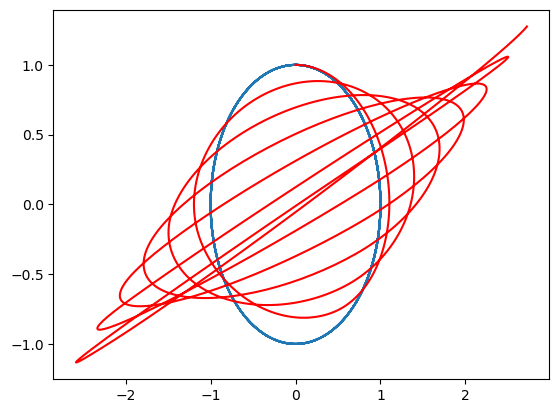

In [18]:
plt.plot(sol[4][:,0], sol[4][:,1])
plt.plot(sol_pert[4][:,0], sol_pert[4][:,1], 'r')

... and thats all I wanted to tell you!